# Concise Implementation of Linear Regression
:label:`sec_linear_concise`

Deep learning has witnessed a sort of Cambrian explosion
over the past decade.
The sheer number of techniques, applications and algorithms by far surpasses the
progress of previous decades. 
This is due to a fortuitous combination of multiple factors,
one of which is the powerful free tools
offered by a number of open-source deep learning frameworks.
Theano :cite:`Bergstra.Breuleux.Bastien.ea.2010`,
DistBelief :cite:`Dean.Corrado.Monga.ea.2012`,
and Caffe :cite:`Jia.Shelhamer.Donahue.ea.2014`
arguably represent the
first generation of such models 
that found widespread adoption.
In contrast to earlier (seminal) works like
SN2 (Simulateur Neuristique) :cite:`Bottou.Le-Cun.1988`,
which provided a Lisp-like programming experience,
modern frameworks offer automatic differentiation
and the convenience of Python.
These frameworks allow us to automate and modularize
the repetitive work of implementing gradient-based learning algorithms.

In :numref:`sec_linear_scratch`, we relied only on
(i) tensors for data storage and linear algebra;
and (ii) automatic differentiation for calculating gradients.
In practice, because data iterators, loss functions, optimizers,
and neural network layers
are so common, modern libraries implement these components for us as well.
In this section, (**we will show you how to implement
the linear regression model**) from :numref:`sec_linear_scratch`
(**concisely by using high-level APIs**) of deep learning frameworks.


In [1]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## Defining the Model

When we implemented linear regression from scratch
in :numref:`sec_linear_scratch`,
we defined our model parameters explicitly
and coded up the calculations to produce output
using basic linear algebra operations.
You *should* know how to do this.
But once your models get more complex,
and once you have to do this nearly every day,
you will be glad of the assistance.
The situation is similar to coding up your own blog from scratch.
Doing it once or twice is rewarding and instructive,
but you would be a lousy web developer
if you spent a month reinventing the wheel.

For standard operations,
we can [**use a framework's predefined layers,**]
which allow us to focus
on the layers used to construct the model
rather than worrying about their implementation.
Recall the architecture of a single-layer network
as described in :numref:`fig_single_neuron`.
The layer is called *fully connected*,
since each of its inputs is connected
to each of its outputs
by means of a matrix--vector multiplication.


In Gluon, the fully connected layer is defined in the `Dense` class.
Since we only want to generate a single scalar output,
we set that number to 1.
It is worth noting that, for convenience,
Gluon does not require us to specify
the input shape for each layer.
Hence we do not need to tell Gluon
how many inputs go into this linear layer.
When we first pass data through our model,
e.g., when we execute `net(X)` later,
Gluon will automatically infer the number of inputs to each layer and
thus instantiate the correct model.
We will describe how this works in more detail later.


In [2]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Dense(1)
        self.net.initialize(init.Normal(sigma=0.01))

In the `forward` method we just invoke the built-in `__call__` method of the predefined layers to compute the outputs.


In [3]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

## Defining the Loss Function


The `loss` module defines many useful loss functions.
For speed and convenience, we forgo implementing our own
and choose the built-in `loss.L2Loss` instead.
Because the `loss` that it returns is
the squared error for each example,
we use `mean`to average the loss across over the minibatch.


In [4]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = gluon.loss.L2Loss()
    return fn(y_hat, y).mean()

## Defining the Optimization Algorithm


Minibatch SGD is a standard tool
for optimizing neural networks
and thus Gluon supports it alongside a number of
variations on this algorithm through its `Trainer` class.
Note that Gluon's `Trainer` class stands
for the optimization algorithm,
while the `Trainer` class we created in :numref:`sec_oo-design`
contains the training method,
i.e., repeatedly call the optimizer
to update the model parameters.
When we instantiate `Trainer`,
we specify the parameters to optimize over,
obtainable from our model `net` via `net.collect_params()`,
the optimization algorithm we wish to use (`sgd`),
and a dictionary of hyperparameters
required by our optimization algorithm.


In [5]:
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return gluon.Trainer(self.collect_params(),
                         'sgd', {'learning_rate': self.lr})

## Training

You might have noticed that expressing our model through
high-level APIs of a deep learning framework
requires fewer lines of code.
We did not have to allocate parameters individually,
define our loss function, or implement minibatch SGD.
Once we start working with much more complex models,
the advantages of the high-level API will grow considerably.

Now that we have all the basic pieces in place,
[**the training loop itself is the same
as the one we implemented from scratch.**]
So we just call the `fit` method (introduced in :numref:`oo-design-training`),
which relies on the implementation of the `fit_epoch` method
in :numref:`sec_linear_scratch`,
to train our model.


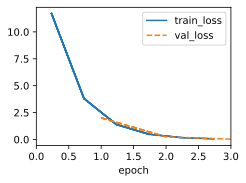

In [6]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=np.array([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Below, we
[**compare the model parameters learned
by training on finite data
and the actual parameters**]
that generated our dataset.
To access parameters,
we access the weights and bias
of the layer that we need.
As in our implementation from scratch,
note that our estimated parameters
are close to their true counterparts.


In [7]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data(), self.net.bias.data())
w, b = model.get_w_b()

## Summary

This section contains the first
implementation of a deep network (in this book)
to tap into the conveniences afforded
by modern deep learning frameworks,
such as MXNet :cite:`Chen.Li.Li.ea.2015`, 
JAX :cite:`Frostig.Johnson.Leary.2018`, 
PyTorch :cite:`Paszke.Gross.Massa.ea.2019`, 
and Tensorflow :cite:`Abadi.Barham.Chen.ea.2016`.
We used framework defaults for loading data, defining a layer,
a loss function, an optimizer and a training loop.
Whenever the framework provides all necessary features,
it is generally a good idea to use them,
since the library implementations of these components
tend to be heavily optimized for performance
and properly tested for reliability.
At the same time, try not to forget
that these modules *can* be implemented directly.
This is especially important for aspiring researchers
who wish to live on the leading edge of model development,
where you will be inventing new components
that cannot possibly exist in any current library.


In Gluon, the `data` module provides tools for data processing,
the `nn` module defines a large number of neural network layers,
and the `loss` module defines many common loss functions.
Moreover, the `initializer` gives access
to many choices for parameter initialization.
Conveniently for the user,
dimensionality and storage are automatically inferred.
A consequence of this lazy initialization is that
you must not attempt to access parameters
before they have been instantiated (and initialized).


## Exercises

1. How would you need to change the learning rate if you replace the aggregate loss over the minibatch
   with an average over the loss on the minibatch?
1. Review the framework documentation to see which loss functions are provided. In particular,
   replace the squared loss with Huber's robust loss function. That is, use the loss function
   $$l(y,y') = \begin{cases}|y-y'| -\frac{\sigma}{2} & \textrm{ if } |y-y'| > \sigma \\ \frac{1}{2 \sigma} (y-y')^2 & \textrm{ otherwise}\end{cases}$$
1. How do you access the gradient of the weights of the model?
1. What is the effect on the solution if you change the learning rate and the number of epochs? Does it keep on improving?
1. How does the solution change as you vary the amount of data generated?
    1. Plot the estimation error for $\hat{\mathbf{w}} - \mathbf{w}$ and $\hat{b} - b$ as a function of the amount of data. Hint: increase the amount of data logarithmically rather than linearly, i.e., 5, 10, 20, 50, ..., 10,000 rather than 1000, 2000, ..., 10,000.
    2. Why is the suggestion in the hint appropriate?


[Discussions](https://discuss.d2l.ai/t/44)
